## Load Libraries 

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [4]:
!unzip ml-latest-small.zip
# Reading ratings file
ratings = pd.read_csv('ml-latest-small/ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('ml-latest-small/movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [5]:
df_movies = movies
df_ratings = ratings

### Most popular genres of movie released

<BarContainer object of 19 artists>

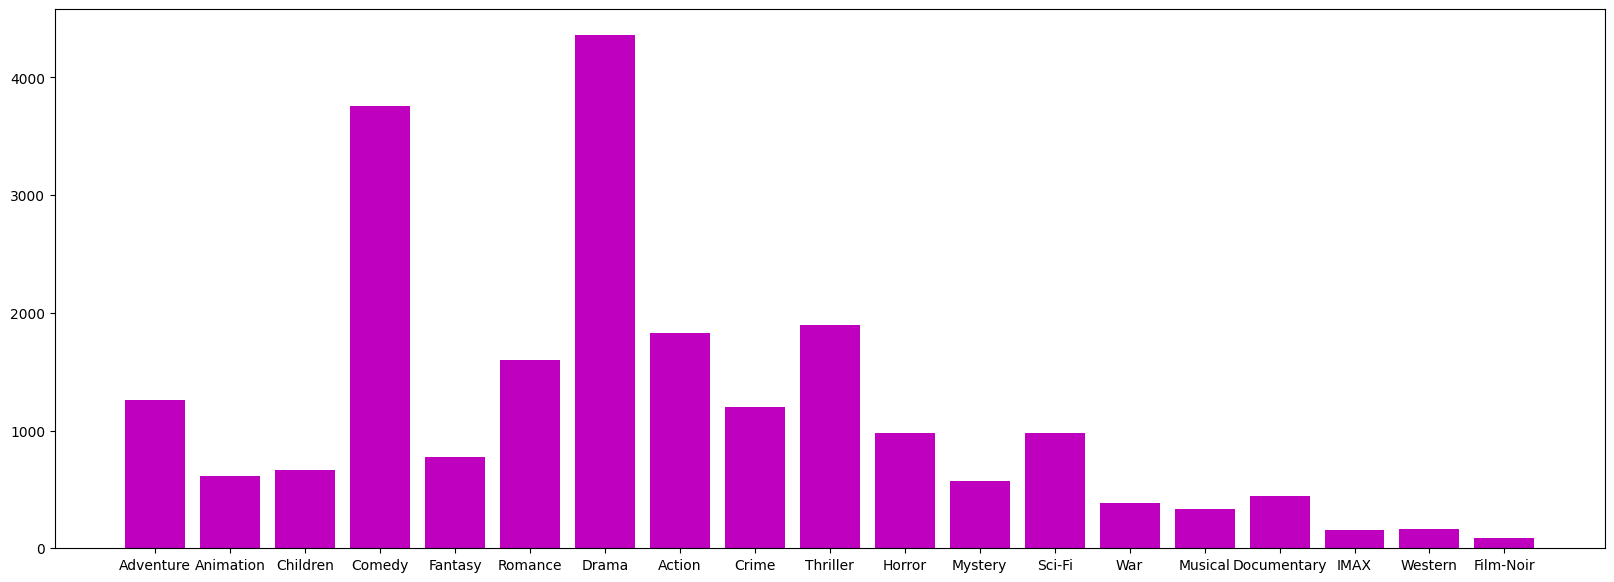

In [6]:
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='m')

### Distribution of users rating

<ipython-input-7-9e1d83c6983d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_ratings["rating"]);


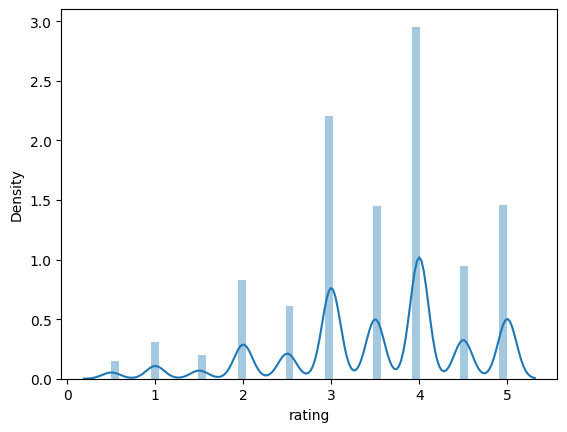

In [7]:
sns.distplot(df_ratings["rating"]);

In [8]:
print("Shape of frames: \n"+ " Rating DataFrame"+ str(df_ratings.shape)+"\n Movies DataFrame"+ str(df_movies.shape))

Shape of frames: 
 Rating DataFrame(100836, 4)
 Movies DataFrame(9742, 3)


In [9]:
merge_ratings_movies = pd.merge(df_movies, df_ratings, on='movieId', how='inner')

In [10]:
merge_ratings_movies = merge_ratings_movies.drop('timestamp', axis=1)

Grouping the rating based on user

In [11]:
ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])
ratings_grouped_by_movies = merge_ratings_movies.groupby('movieId').agg([np.size, np.mean])

<ipython-input-11-56b36a75602e>:1: FutureWarning: ['title', 'genres'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])
<ipython-input-11-56b36a75602e>:2: FutureWarning: ['title', 'genres'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  ratings_grouped_by_movies = merge_ratings_movies.groupby('movieId').agg([np.size, np.mean])


In [12]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)

### Top 10 users who have rated most of the movies

In [13]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)

### Movies with high average rating

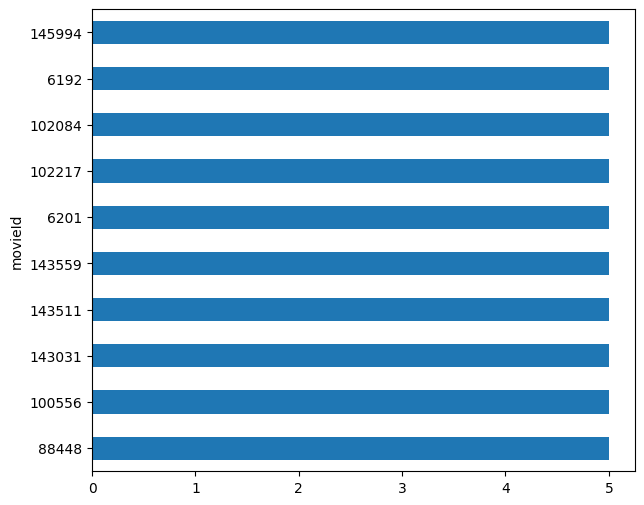

In [14]:
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='barh', figsize=(7,6));

### Movies with low average rating

In [15]:
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5

In [16]:
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]



### Term Frequency (TF) and Inverse Document Frequency (IDF)



**Cosine similarity**


In [17]:
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')
df_movies['genres'] = df_movies['genres'].replace(to_replace="(no genres listed)", value="")
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(df_movies['genres'])
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
print(cosine_sim_movies)

[[1.         0.81357774 0.15276924 ... 0.         0.4210373  0.26758648]
 [0.81357774 1.         0.         ... 0.         0.         0.        ]
 [0.15276924 0.         1.         ... 0.         0.         0.57091541]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.4210373  0.         0.         ... 0.         1.         0.        ]
 [0.26758648 0.         0.57091541 ... 0.         0.         1.        ]]


Content Based Recommendation

In [26]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    idx_movie = df_movies.loc[df_movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)
    sim_scores_movies = sim_scores_movies[1:11]
    movie_indices = [i[0] for i in sim_scores_movies]
    return df_movies['title'].iloc[movie_indices]


In [27]:
get_recommendations_based_on_genres("Batman: The Dark Knight Returns, Part 1 (2012)")

7100    Evangelion: 1.0 You Are (Not) Alone (Evangerio...
8032       Batman: The Dark Knight Returns, Part 1 (2012)
8048                                       Redline (2009)
8246          Justice League: Crisis on Two Earths (2010)
8792    Ghost in the Shell Arise - Border 1: Ghost Pai...
8841                         Patlabor 2: The Movie (1993)
8940                        Ghost in the Shell 2.0 (2008)
9488                           Ultimate Avengers 2 (2006)
9547                    Final Flight of the Osiris (2003)
5669                                Animatrix, The (2003)
Name: title, dtype: object

In [28]:
def get_recommendation_content_model(userId):

    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = df_ratings[df_ratings["userId"] == userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((df_movies["title"][row["movieId"] == df_movies["movieId"]]).values)
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)

    return list(set(recommended_movie_list))[:10]

get_recommendation_content_model(1)


<ipython-input-28-e4cb007f07ce>:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():


['Pearl Harbor (2001)',
 'Scrooged (1988)',
 'Unstrung Heroes (1995)',
 'To Be or Not to Be (1942)',
 'Star Trek: First Contact (1996)',
 "King Solomon's Mines (1950)",
 'Corruptor, The (1999)',
 'Blade (1998)',
 'Anaconda (1997)',
 'Death Becomes Her (1992)']

In [29]:
true_positives = 0
false_positives = 0
false_negatives = 0
p = 0
r = 0
c = 0
f  = 0
def evaluate_content_based_model():

    for key, columns in df_movies.iterrows():
        global p,r,c,f
        c = c+1
        movies_recommended_by_model = get_recommendations_based_on_genres(columns["title"])
        test = df_movies["genres"][movies_recommended_by_model.index]
        predicted_genres = []
        for i in range(0 , len(test)):
          individualType = test.values[i].split("|")
          for j in range(0, len(individualType)):
            if individualType[j] in predicted_genres:
              continue;
            else:
              predicted_genres.append(individualType[j])
        actual_genres = columns["genres"].split('|')
        
        global true_positives, false_positives, false_negatives
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        for predicted_genre in predicted_genres:
            
            if predicted_genre in actual_genres:
                true_positives += 1
            else:
                false_positives += 1
        for actual_genre in actual_genres:
            if actual_genre not in predicted_genres:
                false_negatives += 1
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1score=(2*precision*recall)/(precision+recall) if (precision+recall)!=0 else 0
        p=p+precision
        r=r+recall
        f=f+f1score


evaluate_content_based_model()
p = p/c
r=r/c
f=f/c
print("Precision:", p)
print("Recall:", r)
print("F1 Score: ",f)


Precision: 0.9471367523076648
Recall: 0.9948648952498265
F1 Score:  0.9643677307030076


In [30]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [31]:
df_movies = movies 
df_ratings = ratings 

## Implementation of Item-Item Filtering

In [32]:
df_movies_ratings=pd.merge(df_movies, df_ratings)

In [33]:
df_movies_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


Here Pivot table function is used as we want one to one maping between movies, user and their rating. 
So by default pivot_table command takes average if we have multiple values of one combination.

In [34]:
ratings_matrix_items = df_movies_ratings.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape

(9724, 610)

In [35]:
movie_similarity = 1 - pairwise_distances(ratings_matrix_items.values, metric="cosine")
np.fill_diagonal(movie_similarity, 0) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_items = pd.DataFrame(movie_similarity)
ratings_matrix_items


,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [36]:
def item_similarity(movieName): 
    try:
        user_inp=movieName
        inp=df_movies[df_movies['title']==user_inp].index.tolist()
        inp=inp[0]

        df_movies['similarity'] = ratings_matrix_items.iloc[inp]
        df_movies.columns = ['movie_id', 'title', 'release_date','similarity']
    except:
        print("The movie is not in the database!")

In [37]:
def recommendedMoviesAsperItemSimilarity(user_id):
    user_movie= df_movies_ratings[(df_movies_ratings.userId==user_id) & df_movies_ratings.rating.isin([5,4.5])][['title']]
    user_movie=user_movie.iloc[0,0]
    item_similarity(user_movie)
    sorted_movies_as_per_userChoice=df_movies.sort_values( ["similarity"], ascending = False )
    sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
    recommended_movies=list()
    df_recommended_item=pd.DataFrame()
    user2Movies= df_ratings[df_ratings['userId']== user_id]['movieId']
    for movieId in sorted_movies_as_per_userChoice:
            if movieId not in user2Movies:
                df_new= df_ratings[(df_ratings.movieId==movieId)]
                df_recommended_item=pd.concat([df_recommended_item,df_new])
            best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
    return best10['movieId']

In [38]:
def movieIdToTitle(listMovieIDs):
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(df_movies[df_movies['movie_id']==id]['title'])
    return movie_titles

In [46]:
user_id=20
print("Recommended movies,:\n",movieIdToTitle(recommendedMoviesAsperItemSimilarity(user_id)))

Recommended movies,:
 [512    Beauty and the Beast (1991)
Name: title, dtype: object, 322    Lion King, The (1994)
Name: title, dtype: object, 512    Beauty and the Beast (1991)
Name: title, dtype: object, 512    Beauty and the Beast (1991)
Name: title, dtype: object, 322    Lion King, The (1994)
Name: title, dtype: object, 512    Beauty and the Beast (1991)
Name: title, dtype: object, 512    Beauty and the Beast (1991)
Name: title, dtype: object, 512    Beauty and the Beast (1991)
Name: title, dtype: object, 506    Aladdin (1992)
Name: title, dtype: object]


## Implementation of User-Item Filtering

In similar way as we did for ItemItem similarity we will create a matrix but here we will keep rows as user and columns as movieId as we want a vector of different users.
Then in similar ways we will find distance and similarity between users.

In [48]:
ratings_matrix_users = df_movies_ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users


,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225


Here now we have similarity of users in colums with respective users in row. So if we find maximum value in a column we will get the user with highest similarity. So now we can have a pair of users which are similar.

In [49]:
ratings_matrix_users.idxmax(axis=1)

0      265
1      365
2      312
3      390
4      469
      ... 
605    473
606    569
607    479
608    339
609    248
Length: 610, dtype: int64

In [50]:
ratings_matrix_users.idxmax(axis=1).sample( 10, random_state = 10 )

547     76
241    467
277    337
348    454
218    238
407    278
352     45
97     600
381     20
607    479
dtype: int64

In [51]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()

In [ ]:
df_similar_user.columns=['similarUser']

In [52]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    user2Movies= df_ratings[df_ratings['userId']== userId]['movieId']
    sim_user=df_similar_user.iloc[0,0]
    df_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
    for movieId in df_ratings[df_ratings['userId']== sim_user]['movieId']:
        if movieId not in user2Movies:
            df_new= df_movies_ratings[(df_movies_ratings.userId==sim_user) & (df_movies_ratings.movieId==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
        best10=df_recommended.sort_values(['rating'], ascending = False )[:11]  
    return best10['movieId']

In [ ]:
for user_id in users:
  recommend_movies= movieIdToTitle(getRecommendedMoviesAsperUserSimilarity(user_id))
  print("Movies you should watch are:\n")
  print(recommend_movies)

Streaming output truncated to the last 5000 lines.
Name: title, dtype: object, 275    Stargate (1994)
Name: title, dtype: object]
Movies you should watch are:

[900    Raiders of the Lost Ark (Indiana Jones and the...
Name: title, dtype: object, 1431    Rocky (1976)
Name: title, dtype: object, 742    African Queen, The (1951)
Name: title, dtype: object, 733    It's a Wonderful Life (1946)
Name: title, dtype: object, 939    Terminator, The (1984)
Name: title, dtype: object, 969    Back to the Future (1985)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 1057    Star Trek II: The Wrath of Khan (1982)
Name: title, dtype: object, 1059    Star Trek IV: The Voyage Home (1986)
Name: title, dtype: object, 1939    Matrix, The (1999)
Name: title, dtype: object, 275    Stargate (1994)
Name: title, dtype: object]
Movies you should watch are:

[900    Raiders of the Lost Ark (Indiana Jones and the...
Name: title, dtype: object, 1431    Rocky (1976)
Na

In [ ]:
def get_user_similar_movies( user1, user2 ):
    common_movies = df_movies_ratings[df_movies_ratings.userId == user1].merge(
      df_movies_ratings[df_movies_ratings.userId == user2],
      on = "movieId",
      how = "inner" )
    common_movies.drop(['movieId','genres_x','genres_y', 'timestamp_x','timestamp_y','title_y'],axis=1,inplace=True)
    return common_movies

In [ ]:
get_user_similar_movies(587,511)